# PyQt5 스마트계산기

* 난이도 : ★★★☆☆☆☆☆☆☆
* 필요라이브러리: PyQt5

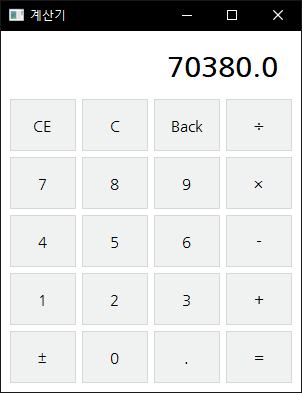

In [ ]:
from PyQt5.QtCore import (Qt)
from PyQt5.QtWidgets import (QMainWindow, QDesktopWidget, QVBoxLayout, QApplication, QGridLayout, QLayout, QLineEdit, QSizePolicy, QToolButton, QWidget, QLCDNumber, QFrame)
from PyQt5.QtCore import (pyqtSlot, QTimer, QTime, Qt, QPoint)


# 연산자 정의
operator = ["+", "-", "*", "/", "="]

# 키 입력을 허용할 키만 정의
include_keys = [42, 46, 47, "+", "-", "*", "/", "=", ".", Qt.Key_Backspace, Qt.Key_Minus, Qt.Key_Plus]

class App(QMainWindow):
    '''QMainWindow 를 사용속받은 계산기 프로그램 본체'''

    def __init__(self):
        '''생성자'''

        # QMainWindow 의 생성사 함수 호출
        super().__init__()

        # 타이틀바가 없는 프레임리스 형태 윈도우에 이동기능을 추가하기 위해 마우스 클릭 여부 판단
        self.mouseClick = False
        self.oldPos = None

        # 윈도우 타이틀바
        self.title = '계산기'
        self.setWindowTitle(self.title)

        # 윈도우 크기 설정
        self.left = 100
        self.top = 200
        self.width = 300
        self.height = 200
        self.setGeometry(self.left, self.top, self.width, self.height)
        self.centerOnScreen()
        
        # 윈도우 내의 커스텀 위젯 생성
        self.table_widget = MyCalculator(self)

        # QMainWindow 는 자체적으로 레이아웃을 보유하고 있습니다.
        # 따라서 QMainWindow 사용시 setCentralWidget 을 하지 않으면 위젯의 배치가 엉망이 됩니다.
        self.setCentralWidget(self.table_widget)

        # 메인 윈도우 배경색상 설정
        self.setStyleSheet("background-color:#FFFFFF")

        self.show()
        

    def centerOnScreen (self):
        '''윈도우 창을 바탕화면 중앙에 띄우기 위한 함수'''

        # 해상도를 구합니다.
        resolution = QDesktopWidget().screenGeometry()

        # 해상도의 중앙 위치로 윈도우를 이동합니다.
        self.move((resolution.width() / 2) - (self.frameSize().width() / 2),
                  (resolution.height() / 2) - (self.frameSize().height() / 2)) 

    def mousePressEvent(self, e):
        if e.button() == Qt.LeftButton:
            self.mouseClick = True
            self.oldPos = e.globalPos()

    def mouseMoveEvent(self, e):
        if self.mouseClick:
            delta = QPoint (e.globalPos() - self.oldPos)
            self.move(self.x() + delta.x(), self.y() + delta.y())
            self.oldPos = e.globalPos()

class Button(QToolButton):
    '''QToolButton 을 상속받아 새로운 버튼 클래스를 만드는 이유는
    계산기의 버튼이 여러개인데 많은 버튼에 일괄적인 스타일을 적용하기 위해 편리성을 위해 만듭니다.'''

    def __init__(self, text, parent=None):
        super(Button, self).__init__(parent)

        # 버튼의 스타일을 설절합니다.
        buttonStyle = '''
        QToolButton:hover { border:1px solid #0078d7; background-color:#e5f1fb; }
        QToolButton:pressed {background-color:#a7c8e3}
        QToolButton {font-size:11pt;font-family:나눔고딕;border:1px solid #d6d7d8;background-color:#f0f1f1;}
        '''
        self.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Preferred)
        self.setText(text)
        self.setStyleSheet(buttonStyle)

    def sizeHint(self):
        '''버튼의 크기를 일괄적으로 변경하기 위한 오버라이딩 함수'''
        size = super(Button, self).sizeHint()
        size.setHeight(size.height() + 30)
        size.setWidth(max(size.width(), size.height()))
        return size

class MyCalculator(QWidget):
    '''계산기의 위젯 클래스'''
    def __init__(self, parent=None):
        super().__init__()

        # 피연산자 대기중을 확인할 변수 (기호 입력 후)
        self.waitingForOperand = True

        # 계산식을 기록할 변수
        self.input_history = ""

        # 계산을 할때 임시로 사용할 변수
        self.input_temporary = ""

        # 계산기의 기본값은 0
        self.display = QLineEdit('0')

        # 어차피 키보드 입력값을 사용하기 때문에 입력창은 사실 출력용 창이라 입력금지
        self.display.setReadOnly(True)

        # 출력창 우측 정렬
        self.display.setAlignment(Qt.AlignRight)

        # 최대 15자리수 까지만 설정
        self.display.setMaxLength(15)

        # 출력창의 스타일 설정(글자체, 글자크기 등)
        self.display.setStyleSheet("border:0px;font-size:20pt;font-family:나눔고딕;font-weight:bold;padding:10px;")

        # 여러개의 버튼을 위치시킬 그리드 레이아웃 생성
        gridLayout = QGridLayout()
        gridLayout.setSizeConstraint(QLayout.SetFixedSize)

        # 각 연산자 버튼 위젯 생성
        # 여기서 주의할것이 버튼에 표기되는 × 이런 값들이 아스키 문자가 아니라 특수 문자입니다.
        # 아스키문자 + 와 특수문자 ＋ 는 바이트수가 달라서 실제 표기될때 특수문자가 좀 더 깔끔해서
        # 그렇게 하는것일뿐 특별한 이유는 없습니다.
        self.clearButton = self.createButton("CE", self.clear)
        self.clearAllButton = self.createButton("C", self.clearAll)
        self.backButton = self.createButton("Back", self.backDelete)
        self.divButton = self.createButton("÷", self.clickButtons)
        self.multiplyButton = self.createButton("×", self.clickButtons)
        self.minusButton = self.createButton("－", self.clickButtons)
        self.plusButton = self.createButton("＋", self.clickButtons)
        self.equalButton = self.createButton("＝", self.clickButtons)
        self.reverseButton = self.createButton("±", self.reverse)
        self.dotButton = self.createButton(".", self.clickButtons)

        # 연산자 버튼 위젯을 그리드에 배치
        gridLayout.addWidget(self.clearButton, 0, 0, 1, 1)
        gridLayout.addWidget(self.clearAllButton, 0, 1, 1, 1)
        gridLayout.addWidget(self.backButton, 0, 2, 1, 1)
        gridLayout.addWidget(self.divButton, 0, 3, 1, 1)
        gridLayout.addWidget(self.multiplyButton, 1, 3, 1, 1)
        gridLayout.addWidget(self.minusButton, 2, 3, 1, 1)
        gridLayout.addWidget(self.plusButton, 3, 3, 1, 1)
        gridLayout.addWidget(self.equalButton, 4, 3, 1, 1)
        gridLayout.addWidget(self.reverseButton, 4, 0, 1, 1)
        gridLayout.addWidget(self.dotButton, 4, 2, 1, 1)

        # 숫자 버튼 생성
        self.digitButtons = []
        for i in range(10):
            self.digitButtons.append(self.createButton(str(i), self.clickButtons))

        # 숫자 0 버튼 위젯 그리드에 배치
        gridLayout.addWidget(self.digitButtons[0], 4, 1, 1, 1)

        # 나머지 숫자 버튼 위젯 그리드에 배치
        for i in range(1, 10):
            row = int(((9 - i) / 3) + 1)
            col = ((i - 1) % 3)
            gridLayout.addWidget(self.digitButtons[i], row, col, 1, 1)
        # gridLayout.addWidget(self.digitButtons[1], 3, 0, 1, 1)
        # gridLayout.addWidget(self.digitButtons[2], 3, 1, 1, 1)
        # gridLayout.addWidget(self.digitButtons[3], 3, 2, 1, 1)
        # gridLayout.addWidget(self.digitButtons[4], 2, 0, 1, 1)
        # gridLayout.addWidget(self.digitButtons[5], 2, 1, 1, 1)
        # gridLayout.addWidget(self.digitButtons[6], 2, 2, 1, 1)
        # gridLayout.addWidget(self.digitButtons[7], 1, 0, 1, 1)
        # gridLayout.addWidget(self.digitButtons[8], 1, 1, 1, 1)
        # gridLayout.addWidget(self.digitButtons[9], 1, 2, 1, 1)

        # 세로 박스 레이아웃 생성
        layout = QVBoxLayout()

        # 출력창을 vbox 레아이웃에 배치
        layout.addWidget(self.display)

        # 그리드레이아웃을 vbox 에 추가
        layout.addLayout(gridLayout)

        # 메인 레이아웃에 vbox 레이아웃 설정
        self.setLayout(layout)

        # 윈도우 타이틀 및 사이즈 설정
        self.setWindowTitle("계산기")
        self.setGeometry(300, 300, 300, 400)

    # 이전 계산기 만들기 강좌에서 사용했던 함수
    # 사용자가 입력된 값을 계산해주는 함수
    def stringCalculator(self, string, show_history=False):
        # 계산에 사용되는 연산자 
        operator = ['+', '-', "*", "/", "="]

        # 최종 계산 결과값을 저장할 변수 (float)
        result = 0.0

        # 문자열의 마지막 연산자 위치를 기억할 변수
        last_operator_pos = 0

        # 실제 계산을 하기 위해 리스트의 위치값을 임시 기억할 변수
        pos = 0

        # 계산식을 임시적으로 보관할 리스트 변수
        stringlist = []

        # 사용자가 입력한 문자열의 마지막 글자가 연산자가 아닌경우
        # 5 + 5 일때 = 문자열을 추가함
        if string[-1] not in operator:
            string += "="


        '''
        ******************************************* 중요!! ****************************************
        하나의 문자열 변수에 있는 계산식을 연산자와 숫자로 분리하는 작업을 먼저 해야함. 
        문자열을 순차적으로 0부터 끝까지 반복하면서 연산자의 위치를 기준으로
        연산자를 만나게 되면 연산자 앞에는 숫자가 있다고 판단하고 숫자를 리스트에 추가하고 뒤의 연산자를 따로 리스트에 추가
        "5 + 5 * 5 ="  라는 식인경우 ['5', '+', '5', '='] 이렇게 분리하기 위함
        *******************************************************************************************
        '''
        # 입력된 문자열 만큼 반복 (마지막 글자는 연산자 =)
        # i 는 현재 반복문의 카운트고 s 는 입력된 문자열중 현재 한 문자
        for i, s in enumerate(string):
            # 현재 문자가 연산자인경우
            if s in operator:
                # 마지막 연산자 위치의 글자가 공백이 아닌경우 에만 동작
                if string[last_operator_pos:i].strip() != "":
                    # 계산식을 보관할 임시 변수 stringlist 에 연산자 앞의 값을 추가
                    stringlist.append(string[last_operator_pos:i])
                    # 계산식을 보관할 임시 변수에 연산자 추가(s 가 연산자)
                    stringlist.append(s)
                    # 최종 연산자의 위치 + 1
                    last_operator_pos = i + 1

        # 임시 분리된 숫자, 연산자 배열에서 마지막 연산자를 제거 (=)
        stringlist = stringlist[:-1]
        
        # 무한루프
        while True:
            # 리스트의 현재 위치가 전체 문자열 갯수보다 크면 반복문 탈출
            if pos + 1 > len(stringlist):
                break
            
            # 분리된 계산식 리스트가 현재위치 + 2 보다 큰경우
            # 분리된 계산식의 현재 요소가 연산자이고 분리된 계산식의 현재 요소 다음 글자도 연산식인경우
            # 5 + -5 이런 경우를 처리 하기 위함
            if len(stringlist) > pos + 2 and stringlist[pos] in operator and stringlist[pos + 1] in operator:
                # 현재 연산자 이전숫자 [pos-1] + 현재 숫자[pos] + 현재 숫자 다음글자 + 현재 숫자 다다음 글자
                # 5 + -5 인경우 + 에서 조건문이 만족되었으니 + 이전인 5와 + 그리고 - 와 5까지 temp 에 저장
                temp = stringlist[pos-1] + stringlist[pos] + stringlist[pos+1] + stringlist[pos+2]
                # 임시 리스트에서 4글자 5 + -5 를 삭제
                del stringlist[0:4]
                # 임시 리스트에서 삭제한 후 다시 맨 앞에 현재 temp의 계산결과 값입력
                # 5 + -5 => 0
                stringlist.insert(0, str(eval(temp)))
                # 현재 위치 초기화
                pos = 0

                if show_history:
                    print(stringlist)

            # 분리된 계산식 리스트가 현재위치 + 1 크기보다 큰 경우
            # 그리고 분리된 계산식 현재 글자가 연산자이고 다음 글자는 연산자가 아닌경우
            # 5 + 5 이런 경우(음수 요소가 아닌경우)
            elif len(stringlist) > pos + 1 and stringlist[pos] in operator and stringlist[pos + 1] not in operator:
                # 현재 연산자 이전 글자(숫자로 판단) + 현재 연산자 + 다음 숫자 를 temp 에 담음
                temp = stringlist[pos-1] + stringlist[pos] + stringlist[pos+1]
                # 임시리스트에서 삭제
                del stringlist[0:3]
                # 임시 리스트에서 다시 맨 앞에 현재 temp의 계산결과 값입력
                stringlist.insert(0, str(eval(temp)))
                # 현재 위치 초기화
                pos = 0

                if show_history:
                    print(stringlist)

            # 루프문에서 조건들은 모두 연산자이니 연산자가 아닌 경우 숫자로 판단하고 pos 값을 연산자가 나올때까지 증가
            # 5432 + 1
            pos += 1

        # 모든 계산이 끝났다면 stringlist 에는 최종 계산 결과 하나만 남아있음
        if len(stringlist) > 0:
            # 최종 계산 결과값을 float 로 형변환 후 result 에 저장
            result = float(stringlist[0])

        # 계산이 정상적으로 마무리 되었다면 result 의 값을 소수점 4자리까지만 잘라서 리턴
        return round(result, 4)

    def clickButtons(self):
        '''버튼 클릭 시그널과 연결된 슬롯'''

        # 시그널이 발생된 버튼을 clickedButton 변수에 저장합니다.
        clickedButton = self.sender()

        # 해당 버튼의 텍스트 값을 구합니다.
        digitValue = clickedButton.text()

        # 버튼의 문자열 값의 아스키코드값으로 0~9 사이의 값인지 확인
        # 실제 버튼의 연산자는 특수문자기 때문에 해당 특수문자에 해당하는 아스키 문자로 바꿔서 변수에 다시 저장
        if ord(digitValue) >= 48 and ord(digitValue) <= 57: digitValue = digitValue
        elif digitValue == "＋": digitValue = "+"
        elif digitValue == "－": digitValue = "-"
        elif digitValue == "×": digitValue = "*"
        elif digitValue == "÷": digitValue = "/"
        elif digitValue == ".": digitValue = "."
        elif digitValue == "＝": digitValue = "="

        # 확인된 digitalValue 의 내용을 상황에 맞게 처리 하기 위해 processKeyValue 함수 호추
        self.processKeyValue(digitValue)

    def inputHistory(self, value):
        '''히스토리 변수에 새로운 내용을 추가하는 함수
        Args:
            value (str) : 추가 계산식
        '''

        # 새로운 값을 문자열로 변환합니다.
        digitValue = str(value)

        # 새로운 값이 연산자인경우
        if digitValue in operator:
            # 히스토리 마지막 글자가 연산자인경우
            # [-1] 로 접근 안하고 [-1:] 로 접근하는 이유는
            # 만약 히스토리 변수가 아무것도 없는 경우 [-1] 은 인덱스 오류가 나기 때문입니다.
            if self.input_history[-1:] in operator:
                # 히스토리에 새로운 값과 연산자를 추가 합니다.
                self.input_history += self.input_temporary + digitValue
            else:
                # 연산자가 없는 경우라면 새로운 값으로 인식하고 새롭게 설정합니다.
                self.input_history = self.input_temporary + digitValue
            # 임시 변수 초기화
            self.input_temporary = ""
        else:
            # 숫자인 경우 연속된 숫자를 더 입력받기 위해 임시 변수에 새로운 값을 추가 합니다.
            self.input_temporary += str(digitValue)

    def processKeyValue(self, key):
        '''입력된 내용을 계산해야하는지 계속 기억해야하는지 등을 판단하기 위한 함수
        Args:
            key (str) : 현재 입력된 내용
        '''

        # = 가 입력되었다면
        if key == "=":
            # calculator 함수를 호출하여 계산을 합니다.
            if self.calculator(clear=True):
                # 연산자 대기 상태로 변경합니다.
                self.waitingForOperand = True

        # 입력된 키가 연산자인경우
        elif key == "+" or key == "-" or key == "*" or key == "/":
            # 연산자 대기 상태인 경우에 연산자가 입력된경우는 연산자를 교체 합니다.
            if self.waitingForOperand:
                # 연산자 교체
                self.replaceLastOperator(key)
            else:
                # 연산자 대기 상태가 아닌데 연산자가 입력된 경우는 히스토리에 추가하고 계산 합니다.
                self.inputHistory(key)
                self.calculator()
            # 연산자가 입력되었으니 연산자 대기 상태로 변경
            self.waitingForOperand = True
        elif key == ".":
            # 연산자 대기 상태인경우
            if self.waitingForOperand:
                # 소수점을 진행하기 위해 0 을 앞에 추가 합니다.
                self.display.setText('0')
            # 소수점이 현재 창에 없는 경우(소수점 중복 방지)
            if "." not in self.display.text():
                # 입력된 값 뒤에 소수점을 붙입니다.
                self.display.setText(self.display.text() + ".")
                # 히스토리에 추가
                self.inputHistory(str("."))
            # 연산자 대기 상태로 변경
            self.waitingForOperand = False
        else:
            # 입력된 값에 해당하는 아스키값을 구합니다.
            keyvalue = ord(key)
            # 아스키값이 0~9 사이인경우
            if keyvalue >= 48 and keyvalue <= 57:
                digitValue = key
                # 현재 값이 0 인데 0을 입력한경우에는 무시
                if self.display.text() == '0' and digitValue == 0.0:
                    return
                # 연산자 대기 모드인경우
                if self.waitingForOperand:
                    # 현재 텍스트를 모두 지우고
                    self.display.clear()
                    # 연산자 대기 상태가 아닌상태로 변경합니다.(숫자 연속 입력)
                    self.waitingForOperand = False
                # 현재 텍스트에 추가된 내용을 이어 붙이기 합니다. (문자열 1 + 2 + 3)
                self.display.setText(self.display.text() + str(digitValue))

                # 히스토리에 추가 합니다.
                self.inputHistory(str(digitValue))
    
    def replaceLastOperator(self, value):
        '''마지막 연산자를 새로운 연산자로 교체하는 함수

        Args:
            value (str) : 입력된 새로운 연산자
        '''
        # 히스토리 변수의 마지막을 새로운 연산자로 변경하여 새로 저장합니다.
        self.input_history = self.input_history[:-1] + str(value)

    def calculator(self, clear=None):
        '''실제 히스토리의 내용을 계산하는 함수 입니다.
        
        Args:
            clear (bool) : 

        Returns:
            bool : 계산 성공여부
        '''

        # 만약 히스토리에 연산자가 없다는 오류를 가정하고 체크 하기 위한 변수
        operator_check = False

        # 입력된 히스토리에 연산자가 있는지 확인합니다. 오류방지목적
        for i in self.input_history:
            if i in operator:
                operator_check = True
                break

        # 연산자가 없으면 그냥 리턴 합니다.
        if not operator_check:
            return False
        else:
            # 마지막 입력중이던 값까지 더해서 히스토리를 완성합니다.
            self.input_history += self.input_temporary

            # 임시 변수를 초기화 합니다.
            self.input_temporary = ""

            # 계산 후 결과를 출력합니다.
            self.display.setText(str(self.stringCalculator(self.input_history)))
        if clear:
            # 최종 히스토리에 최종 결과값을 저장합니다.
            self.input_history = str(self.stringCalculator(self.input_history))
        return True

    def keyPressEvent(self, e):
        ''' 입력된 키보드 값 처리 함수'''
        if e.key() == Qt.Key_Backspace:
            self.backDelete()
        elif e.key() == Qt.Key_Enter:
            self.processKeyValue("=")
        elif e.key() >= 47 and e.key() <= 57:
            self.processKeyValue(chr(e.key()))
        elif e.key() == 42 or e.key() == 43 or e.key() == 45 or e.key() == 46:
            self.processKeyValue(chr(e.key()))

    def backDelete(self):
        '''백스페이스가 입력된 경우 호출되는 함수'''

        # 연산자 대기 모드인경우에는 백스페이스키로 지울게 없음
        if self.waitingForOperand: return

        # 현재 입력창의 텍스트에서 마지막 한글자를 빼고 text에 저장
        text = self.display.text()[:-1]
        # 임시 변수에 저장
        self.input_temporary = text

        # 입력된 텍스트가 없으면
        if not text:
            text = '0'
            self.input_temporary = ""
            self.waitingForOperand = True
        # 텍스트를 다시 출력
        self.display.setText(text)

    def reverse(self):
        '''음수<->양수'''

        # 현재 입력된 내용을 구합니다.
        text = self.display.text()

        # float 형태로 형 변환 합니다.
        value = float(text)

        # 양수인경우
        if value > 0.0:
            text = "-" + text
        # 음수인경우
        elif value < 0.0:
            text = text[1:]

        # 다시 출력합니다.
        self.display.setText(text)

        # 기호가 바뀐 내용을 임시변수에 다시 설정 합니다.
        self.input_temporary = text

    def clear(self):
        '''입력창 초기화'''
        # 연산자 대기 모드인 경우
        if self.waitingForOperand: return
        # 출력창 0 으로 설정
        self.display.setText('0')
        # 임시변수 초기화
        self.input_temporary = ""
        # 연산자 대기모드
        self.waitingForOperand = True

    def clearAll(self):
        '''내용 전체 초기화'''
        # 출력창 0으로 설정
        self.display.setText('0')
        # 임시변수, 히스토리변수 모두 초기화
        self.input_temporary = ""
        self.input_history = ""
        # 연산자 대기 모드
        self.waitingForOperand = True

    def createButton(self, text, member):
        '''숫자 버튼 생성 및 시그널 연결'''
        button = Button(text)
        button.clicked.connect(member)
        return button

if __name__ == "__main__":
    import sys
    print(sys.argv)
    app = QApplication(sys.argv)
    calc = App()
    sys.exit(app.exec_())
